In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Apr  2 15:56:55 2017

@author: Runjing Liu
"""
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from copy import deepcopy

from beta_process_vb_lib import *

%matplotlib inline

# np.random.seed(50)



In [2]:
N = 500 # sample size
D = 2 # dimension
# so X will be a n\times D matrix

K_inf = 5 # truncation parameter for sampling

alpha = 5 # IBP parameter
v = np.zeros(K_inf) # Beta sticks
Pi = np.zeros(K_inf)
Z = np.zeros([N,K_inf])

# Parameters to draw A from MVN
mu = np.zeros(D)
sigma_A = 1

sigma_eps = 0.5 # variance of noise

# Draw Z from truncated stick breaking process
for k in range(K_inf):
    v[k] = np.random.beta(alpha,1)
    if k != 0:
        Pi[k] = Pi[k-1] * v[k]
    else:
        Pi[k] = v[k]

    for n in range(N):
        Z[n,k] = np.random.binomial(1,Pi[k])

print(Z[0:10,:])

# Draw A from multivariate normal
A = np.random.multivariate_normal(mu, sigma_A*np.identity(D), K_inf)

# draw noise
epsilon = np.random.multivariate_normal(np.zeros(D), sigma_eps*np.identity(D), N)

# the observed data
X = np.dot(Z,A) + epsilon

K = 5 # variational truncation



[[ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  1.]
 [ 1.  1.  0.  1.  0.]
 [ 1.  1.  0.  1.  0.]
 [ 0.  0.  0.  1.  1.]
 [ 0.  0.  1.  0.  0.]
 [ 1.  1.  1.  1.  0.]
 [ 1.  1.  1.  0.  0.]
 [ 1.  1.  1.  0.  1.]
 [ 0.  0.  0.  0.  0.]]


In [3]:
# Variational parameters
tau = np.random.uniform(0,1,[K,2]) # tau1, tau2 -- beta parameters for v
nu = np.random.uniform(0,1,[N,K]) # Bernoulli parameter for z_nk
#nu = deepcopy(Z)
phi_mu = np.random.normal(0,1,[D,K]) # kth mean (D dim vector) in kth column
#phi_mu = deepcopy(A).T
phi_var = {k: np.identity(D) for k in range(K)}


    # Term7 and term 5 give NaNs. Term7 bc nu is close to 1; term 5 bc tau's are large!?
iterations = 100
elbo = np.zeros(iterations)
Term1 = np.zeros(iterations)
Term2 = np.zeros(iterations)
Term3 = np.zeros(iterations)
Term4 = np.zeros(iterations)
Term5 = np.zeros(iterations)
Term6 = np.zeros(iterations)
Term7 = np.zeros(iterations)

In [4]:
#print(A)
#input('pause')

for i in np.arange(iterations):


    for k in np.arange(K):
        tau = Tau_updates(tau, nu, alpha, D, N, K, n, k)

    for k in np.arange(K):
        Expectation_k = Exp_true(tau, k)
        for n in np.arange(N):
            nu = Nu_updates(Expectation_k, tau, nu, phi_mu, phi_var, sigma_eps, X, D, N, K, n, k)

    for k in np.arange(K):
        [phi_var, phi_mu] = Phi_updates(nu, phi_mu, phi_var, X, sigma_A, sigma_eps, D, N, K, n, k)

    #print('true')
    #print(A)

    #print('estimate')
    #print(phi_mu.T)
    #input('pause')

    [elbo[i], Term1[i], Term2[i], Term3[i], Term4[i], Term5[i], Term6[i], Term7[i]] = \
        Elbo(tau, nu, phi_mu, phi_var, X, sigma_A, sigma_eps, alpha, D, K, N)
    print('iteration: ', i)
    print('ELbo')
    print(elbo[i])

    #print('Z')
    #print(Z[0:10,:])

    #print('nu')
    round_nu = np.round(nu * (nu >= 0.9) + nu * (nu <= 0.1)) + nu * (nu >= 0.1) * (nu <= 0.9)

    print(round_nu[0:10, :])

    # input("paused")

    if np.abs(elbo[i] - elbo[i - 1]) <= 10^(-5):
        break



('iteration: ', 0)
ELbo
-17419.3323716
[[ 1.          0.          0.70032243  0.77934513  0.        ]
 [ 0.15013888  0.47854365  0.77668881  0.69687358  0.        ]
 [ 0.87198657  0.28055711  0.31213536  0.32296644  0.6027904 ]
 [ 0.38521787  0.20482317  0.39644805  0.73856539  0.21156075]
 [ 0.82333236  0.51075148  0.82804495  1.          0.        ]
 [ 0.          0.          0.          0.24751623  0.        ]
 [ 0.          0.          0.11838375  0.31498903  0.36595437]
 [ 0.          0.          0.35014139  1.          0.        ]
 [ 0.          0.          0.84365297  1.          0.        ]
 [ 0.          0.          0.11289345  0.2359165   0.        ]]
('iteration: ', 1)
ELbo
-9633.24034604
[[ 0.69031736  0.40517466  0.46136596  0.75611648  0.        ]
 [ 0.40208386  0.43222596  0.41658478  0.64585245  0.        ]
 [ 0.76514176  0.83089684  0.31110157  0.23077858  0.63120902]
 [ 0.47193245  0.58594141  0.25385527  0.33905655  0.15969351]
 [ 0.84193381  1.          0.45842042  

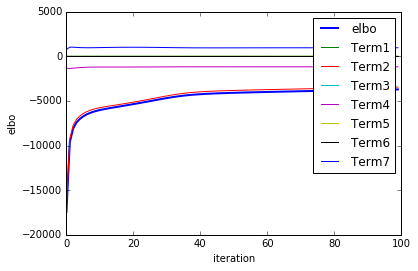

In [5]:

plt.figure(1)
plt.clf()
plt.plot(np.arange(iterations), elbo, linewidth=2.0)
plt.plot(np.arange(iterations), Term1)
plt.plot(np.arange(iterations), Term2)
plt.plot(np.arange(iterations), Term3)
plt.plot(np.arange(iterations), Term4)
plt.plot(np.arange(iterations), Term5)
plt.plot(np.arange(iterations), Term6)
plt.plot(np.arange(iterations), Term7)
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.legend(['elbo', 'Term1', 'Term2', 'Term3', 'Term4', 'Term5', 'Term6', 'Term7'])
